# Long Term Credit Rating Projection 

## Import of all the packages needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.imputation.mice import MICE, MICEData
# import fancyimpute
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import time
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
#import all the functions we wrote ourselves
import import_ipynb
import Functions as functions

importing Jupyter notebook from Functions.ipynb
Note: you may need to restart the kernel to use updated packages.


## Importing and Preprocessing Data

Get the 3 provided csv and merge them into one Pandas-Dataframe.

In [2]:
#Add Keyfigures 
arr1=pd.read_csv("Keyfigures.csv")
#Add Ratings
arr2=pd.read_csv("Ratings.csv")
#Add S&P500 Company List
arr3=pd.read_csv("SP500_CompanyList.csv")
#Combine Keyfigures and S&P500 Company List
rest=functions.combine_keyfigures_and_Companies(arr1,arr3)
#Add Ratings to the mapping
mapping=functions.combine_Ratings_and_Rest(rest,arr2)

Save the joint Dataframe for further use in a csv:

In [3]:
#mapping.to_csv(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Data\Clean Mapping.csv')

In [4]:
#df = pd.read_csv(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Data\Clean Mapping.csv', sep=';',
                #parse_dates=['adate', 'qdate', 'public_date', 'datadate'])
df = mapping
df=df.rename(columns={'public_date_x':'public_date'})
df=df.rename(columns={'TICKER_x':'TICKER'})
df=df.rename(columns={'TICKER_y':'tic'})
df= df.drop(['public_date_y'],1)

Deleting all the rows where splticrm has NA values.

In [5]:
df = df[df['splticrm'].notna()]

In [6]:
df = df[df['splticrm'] != 'D']
df = df[df['splticrm'] != 'CCC']
print(df.head())

   permno       adate     qdate public_date   CAPEI     bm     evm  \
0   10104  20090531.0  20091130  2010-01-31  26.386  0.252  10.110   
1   10104  20090531.0  20091130  2010-02-28  28.226  0.252  10.110   
2   10104  20090531.0  20091130  2010-03-31  29.464  0.252  10.110   
3   10104  20090531.0  20100228  2010-04-30  28.783  0.233  10.983   
4   10104  20090531.0  20100228  2010-05-31  25.096  0.233  10.983   

   pe_op_basic  pe_op_dil  pe_exi  ...     CUSIP  NWPERM    PRC  \
0       19.217     19.378  20.052  ...  68389X10       0  44.06   
1       20.542     20.714  21.435  ...  68389X10       0  44.06   
2       21.425     21.605  22.357  ...  68389X10       0  44.06   
3       21.378     21.556  23.096  ...  68389X10       0  44.06   
4       18.653     18.808  20.152  ...  68389X10       0  44.06   

              key    gvkey  splticrm    datadate         conm   tic      cusip  
0  2010-01-31ORCL  12142.0         A  20100131.0  ORACLE CORP  ORCL  68389X105  
1  2010-02-28O

In [7]:
Y = pd.factorize(df["splticrm"])[0]
print(np.bincount(Y))
print(pd.factorize(df["splticrm"])[1])
Y = pd.DataFrame(Y, columns=["Rating as Factor"])
print(Y)

[3656 1943  990  296 5455 3209  489 3882 4682  199   50  143  382 1069
 1648 1096  220]
Index(['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+',
       'CCC+', 'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
      dtype='object')
       Rating as Factor
0                     0
1                     0
2                     0
3                     0
4                     0
...                 ...
29404                 8
29405                 8
29406                 8
29407                 8
29408                 8

[29409 rows x 1 columns]


After taking a first look at the data we see that for ratings D and CCC we only have 4, respectively 2 observations. Therefore we delete these values due to the very low number of observations.

### Handling missing data
We decided to drop columns which contain more than 10'000 (corresponds to roughly 30%)  NA values or zero values.

In [8]:
NAs = df.isnull().sum() > 10000
Zeros =  (df == 0).sum() > 10000
delNAs = df.columns[NAs] #drops PEG_trailing
delZeros= df.columns[Zeros] #drops rd_sale, adv_sale, staff_sale
df = df.drop(delNAs, axis=1)
df = df.drop(delZeros, axis=1)
df.to_csv(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Collection\ML_Finance-master\Clean Mapping.csv')

Create a column of Ratings which are lagging by 1 Month and merge it with the dataframe

In [9]:
nest_list=functions.create_lagging_Ratings_1M(r'C:\Users\Sandro\OneDrive\Dokumente\Universität Zürich\Aufbaustufe\2020 FS\Introduction to Machine Learning\Group Project\Collection\ML_Finance-master\Clean Mapping.csv')
dframe=pd.DataFrame(nest_list,columns=['key','Lagging-Rating_1M'])
#Replace the Nonetype from python with NaN from pandas
dframe.fillna(value=pd.np.nan, inplace=True)
#Now merge the new Dataframe to our main-df
df = df.merge(dframe, how='left', on=['key'])
df.head()

,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,...,CUSIP,PRC,key,gvkey,splticrm,datadate,conm,tic,cusip,Lagging-Rating_1M
0,10104,20090531.0,20091130,2010-01-31,26.386,0.252,10.110,19.217,19.378,20.052,...,68389X10,44.06,2010-01-31ORCL,12142.0,A,20100131.0,ORACLE CORP,ORCL,68389X105,A
1,10104,20090531.0,20091130,2010-02-28,28.226,0.252,10.110,20.542,20.714,21.435,...,68389X10,44.06,2010-02-28ORCL,12142.0,A,20100228.0,ORACLE CORP,ORCL,68389X105,A
2,10104,20090531.0,20091130,2010-03-31,29.464,0.252,10.110,21.425,21.605,22.357,...,68389X10,44.06,2010-03-31ORCL,12142.0,A,20100331.0,ORACLE CORP,ORCL,68389X105,A
3,10104,20090531.0,20100228,2010-04-30,28.783,0.233,10.983,21.378,21.556,23.096,...,68389X10,44.06,2010-04-30ORCL,12142.0,A,20100430.0,ORACLE CORP,ORCL,68389X105,A
4,10104,20090531.0,20100228,2010-05-31,25.096,0.233,10.983,18.653,18.808,20.152,...,68389X10,44.06,2010-05-31ORCL,12142.0,A,20100531.0,ORACLE CORP,ORCL,68389X105,A


Assign to X all the columns but splticrm. Then we drop some columns which will not be relevant for the algorithms.

In [10]:
X = df.loc[:, df.columns != "splticrm"]
X = X.drop(["permno", "CUSIP", "NCUSIP", "adate", "qdate", "public_date", "TICKER"], axis=1)
X = X.drop(["COMNAM", "PERMCO", "gvkey", "datadate", "tic", "cusip", "conm", "PRC"], axis=1)
X.head()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward,date,key,Lagging-Rating_1M
0,26.386,0.252,10.110,19.217,19.378,20.052,20.052,4.976,13.353,0.129,...,0.912,1.894,0.058,4.145,.867%,2.221,1.554,29/06/2018,2010-01-31ORCL,A
1,28.226,0.252,10.110,20.542,20.714,21.435,21.435,5.323,14.285,0.129,...,0.912,1.894,0.058,4.434,.811%,2.058,1.520,29/06/2018,2010-02-28ORCL,A
2,29.464,0.252,10.110,21.425,21.605,22.357,22.357,5.556,14.911,0.129,...,0.912,1.894,0.058,4.628,.778%,2.146,1.586,29/06/2018,2010-03-31ORCL,A
3,28.783,0.233,10.983,21.378,21.556,23.096,23.096,5.381,15.909,0.177,...,0.902,1.891,0.049,4.515,.773%,1.848,1.642,29/06/2018,2010-04-30ORCL,A
4,25.096,0.233,10.983,18.653,18.808,20.152,20.152,4.692,13.871,0.177,...,0.902,1.891,0.049,3.937,.886%,1.612,1.432,29/06/2018,2010-05-31ORCL,A


### Handling missing data
We decided to drop columns which contain more than 10'000 (corresponds to roughly 30%)  NA values or zero values.

In [11]:
'''
NAs = X.isnull().sum() > 10000
Zeros =  (X == 0).sum() > 10000
delNAs = X.columns[NAs] #drops PEG_trailing
delZeros= X.columns[Zeros] #drops rd_sale, adv_sale, staff_sale
X = X.drop(delNAs, axis=1)
X = X.drop(delZeros, axis=1)
'''

'\nNAs = X.isnull().sum() > 10000\nZeros =  (X == 0).sum() > 10000\ndelNAs = X.columns[NAs] #drops PEG_trailing\ndelZeros= X.columns[Zeros] #drops rd_sale, adv_sale, staff_sale\nX = X.drop(delNAs, axis=1)\nX = X.drop(delZeros, axis=1)\n'

Now we split the data into a train and a test set. The test set consists of 20% of the whole dataset.

In [12]:
#now do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

In [13]:
X_train.head(1)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward,date,key,Lagging-Rating_1M
6595,36.03,0.235,12.83,11.986,12.131,13.943,6.876,1.884,13.644,0.334,...,2.794,4.008,0.062,4.444,1.33%,0.978,1.281,29/06/2018,2014-05-31PPG,A-


In [14]:
X_train.isna().sum()

CAPEI                  47
bm                    529
evm                    76
pe_op_basic           274
pe_op_dil             278
                     ... 
PEG_1yrforward        799
PEG_ltgforward       1286
date                    0
key                     0
Lagging-Rating_1M     313
Length: 70, dtype: int64

We see that there are still missing values that have to be imputed. We do this in the next section.

#### Iterative Imputer
The iterative imputer imputes missing values by by modeling each feature containing missing values as a function of other features and is applied separately to the train and test set.

In [15]:
# apply IterativeImputer
## this can be deleted once the functions file is imported

num_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 
            'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
            'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
            'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
            'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
            'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
            'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
            'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'accrual', 'ptb',
            'DIVYIELD', 'PEG_1yrforward', 'PEG_ltgforward']

# Copy df to df_mice_imputed
X_train_imputed = X_train[num_cols].copy(deep=True)

#Remove "%" from the DIVYIELD-Col
X_train_imputed['DIVYIELD'] = X_train_imputed['DIVYIELD'].str.rstrip('%').astype('float') / 100.0
#X_train_imputed.to_csv("Zwischencheck.csv")

# Initialize IterativeImputer
#mice_imputer = IterativeImputer(random_state=0)

# Impute using fit_tranform on diabetes
#X_train_imputed.iloc[:, :] = mice_imputer.fit_transform(X_train_imputed[num_cols])

# Copy df to df_mice_imputed
X_test_imputed = X_test[num_cols].copy(deep=True)
X_test_imputed['DIVYIELD'] = X_test_imputed['DIVYIELD'].str.rstrip('%').astype('float') / 100.0

# Impute using tranformation of training set on test set
#X_test_imputed.iloc[:, :] = mice_imputer.transform(X_test_imputed[num_cols])

In [16]:
# apply IterativeImputer

X_train_imputed = functions.my_iterative_imputer(X_train_imputed)
X_test_imputed = functions.my_iterative_imputer(X_test_imputed)
X_train_imputed.head(5)

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,accrual,ptb,DIVYIELD,PEG_1yrforward,PEG_ltgforward
6595,36.030,0.235,12.830,11.986,12.131,13.943,6.876,1.884,13.644,0.334,...,4.891,4.585000,1.665,2.794,4.008000,0.062,4.444,0.013300,0.978,1.281
26131,24.356,0.393,9.100,17.627,17.899,23.241,23.241,3.769,18.027,0.175,...,5.000,6.532000,0.594,0.757,1.534000,0.022,2.809,0.008430,3.612,2.702
8093,14.467,0.832,9.315,12.139,12.222,12.277,12.277,1.501,5.596,0.476,...,6.879,9.363000,0.463,1.046,19.433152,0.042,1.130,0.040700,3.300,2.120
23847,68.029,0.144,78.392,-189.570,-189.570,-41.726,-41.726,4.607,23.161,0.000,...,6.584,16.144603,0.804,1.248,1.879000,0.157,6.494,0.020146,-1.162,-0.844
25714,20.875,1.758,9.894,13.230,13.339,22.732,22.417,0.757,3.751,0.547,...,0.729,2.478718,0.773,1.097,19.560173,0.014,0.725,0.022700,6.317,2.479


#### Create train and test data with lagging ratings

In [17]:
#Save lagging ratings
lag_rating_train = X_train["Lagging-Rating_1M"]
lag_rating_test = X_test["Lagging-Rating_1M"]

#Merge imputed data with lagging ratings
X_train_imputed_lag = X_train_imputed.copy()
X_test_imputed_lag = X_test_imputed.copy()

X_train_imputed_lag["Lagging-Rating_1M"] = lag_rating_train
X_test_imputed_lag["Lagging-Rating_1M"] = lag_rating_test

#Define indetificator for train/test set in order to combine, modify and separate them again
X_train_imputed_lag["train"] = 1
X_test_imputed_lag["train"] = 0

#Combine both to factorize lagged ratings together
combined = pd.concat([X_train_imputed_lag, X_test_imputed_lag])

#Drop rows with NA in lagged rating
combined = combined[combined["Lagging-Rating_1M"].notna()]
combined["Lagging-Rating_1M"] = pd.factorize(combined["Lagging-Rating_1M"])[0]

#Separate train and test set
X_train_imputed_lag = combined[combined["train"] == 1]
X_test_imputed_lag = combined[combined["train"] == 0]
X_train_imputed_lag.drop(["train"], axis=1, inplace=True)
X_test_imputed_lag.drop(["train"], axis=1, inplace=True)

#Get the lagging ratings Dataframes Y for train and test set
y_train_lag = X_train_imputed_lag["Lagging-Rating_1M"]
y_test_lag = X_test_imputed_lag["Lagging-Rating_1M"]

y_train_lag = pd.DataFrame(y_train_lag)
y_test_lag = pd.DataFrame(y_test_lag)

#Drop Lagging Raating out of imputed feature matrix
X_train_imputed_lag.drop(["Lagging-Rating_1M"], axis=1, inplace=True)
X_test_imputed_lag.drop(["Lagging-Rating_1M"], axis=1, inplace=True)

y_train_lag.head(5)

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Lagging-Rating_1M
6595,0
26131,0
8093,0
23847,1
25714,0


### Feature Selection
#### For ordinary ratings
To find out which variables are most important we run the 'features_selection' function and select all variables which explain more than 1.5%.

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) cfm     0.0299
 2) intcov_ratio 0.0294
 3) int_totdebt 0.0292
 4) gpm     0.0232
 5) lt_debt 0.0222
 6) inv_turn 0.0222
 7) totdebt_invcap 0.0220
 8) pe_op_basic 0.0207
 9) rect_turn 0.0203
10) CAPEI   0.0201
11) lt_ppent 0.0193
12) debt_invcap 0.0184
13) DIVYIELD 0.0183
14) dpr     0.0177
15) invt_act 0.0177
16) cash_conversion 0.0176
17) debt_assets 0.0175
18) de_ratio 0.0173
19) sale_equity 0.0171
20) opmbd   0.0170
21) debt_at 0.0170
22) quick_ratio 0.0166
23) intcov  0.0165
24) npm     0.0165
25) debt_ebitda 0.0163
26) pay_turn 0.0159
27) rect_act 0.0159
28) ps      0.0157
29) ptpm    0.0156
30) pretret_earnat 0.0156
31) cash_ratio 0.0154
32) roce    0.0152
33) pretret_noa 0.0151
34) GProf   0.0150
35) capital_ratio 0.0150


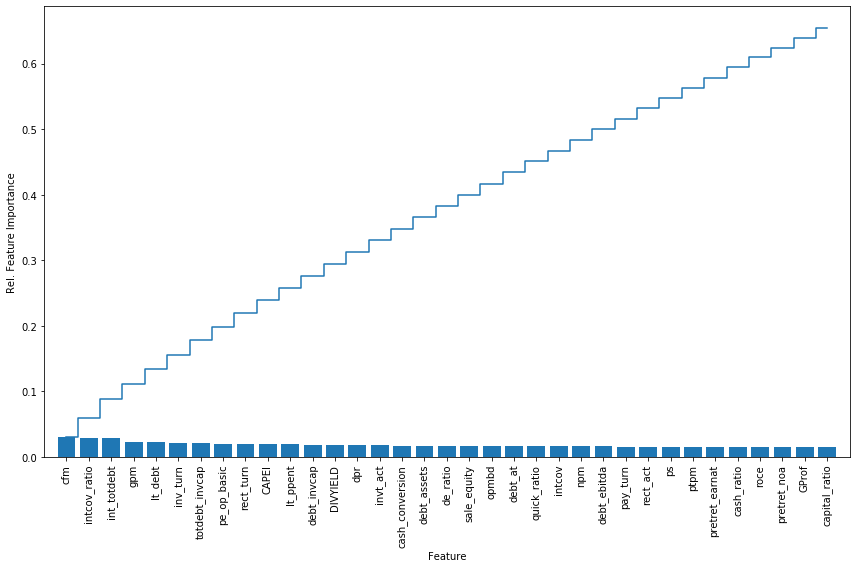

In [18]:
important_features = functions.feature_selection(x = X_train_imputed, y = y_train.values.ravel(), thres=0.015)

In [19]:
#Subset important features matrix for ML algorithms
X_train_imputed = X_train_imputed.loc[:,important_features]
X_test_imputed = X_test_imputed.loc[:, important_features]
X_train_imputed.head(5)

,cfm,intcov_ratio,int_totdebt,gpm,lt_debt,inv_turn,totdebt_invcap,pe_op_basic,rect_turn,CAPEI,...,pay_turn,rect_act,ps,ptpm,pretret_earnat,cash_ratio,roce,pretret_noa,GProf,capital_ratio
6595,0.113,8.40600,0.060000,0.423,0.309,4.554000,0.382,11.986,4.891,36.030,...,4.585000,0.379000,1.884,0.092,0.164000,0.514000,0.202,0.271000,0.381,0.389
26131,0.245,21.13200,0.040000,0.803,0.523,0.844000,0.215,17.627,5.000,24.356,...,6.532000,0.237000,3.769,0.215,0.283000,1.725000,0.184,0.341000,0.399,0.215
8093,0.254,2.96900,0.048000,0.311,0.471,11.322000,0.640,12.139,6.879,14.467,...,9.363000,0.434000,1.501,0.144,0.068000,0.066000,0.085,0.081000,0.089,0.557
23847,-0.054,-12.13433,-0.048348,0.899,0.367,-62.509417,0.356,-189.570,6.584,68.029,...,16.144603,0.144000,4.607,-0.003,0.009000,1.611000,0.008,0.017000,0.448,0.356
25714,0.028,5.34100,0.042000,0.101,0.034,67.877000,0.348,13.230,0.729,20.875,...,2.478718,1.302471,0.757,0.044,2.609797,-2.075346,0.072,-4.369323,0.008,0.292


In [20]:
X_train_imputed.to_csv('X_train.csv')
X_test_imputed.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

#### For lagging ratings
Same approach as before. We select all the variables which explain more than 1.5%.

/Users/Rak/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) cfm     0.0289
 2) intcov_ratio 0.0284
 3) debt_ebitda 0.0254
 4) CAPEI   0.0253
 5) debt_capital 0.0249
 6) gpm     0.0248
 7) inv_turn 0.0228
 8) dpr     0.0223
 9) lt_debt 0.0214
10) rect_turn 0.0213
11) rect_act 0.0204
12) debt_assets 0.0201
13) invt_act 0.0199
14) int_totdebt 0.0196
15) cash_conversion 0.0192
16) lt_ppent 0.0185
17) npm     0.0183
18) DIVYIELD 0.0181
19) opmbd   0.0178
20) debt_at 0.0176
21) sale_equity 0.0176
22) at_turn 0.0170
23) int_debt 0.0168
24) de_ratio 0.0166
25) profit_lct 0.0165
26) pay_turn 0.0163
27) totdebt_invcap 0.0161
28) debt_invcap 0.0157
29) pretret_noa 0.0153
30) opmad   0.0151
31) GProf   0.0151
32) sale_invcap 0.0151


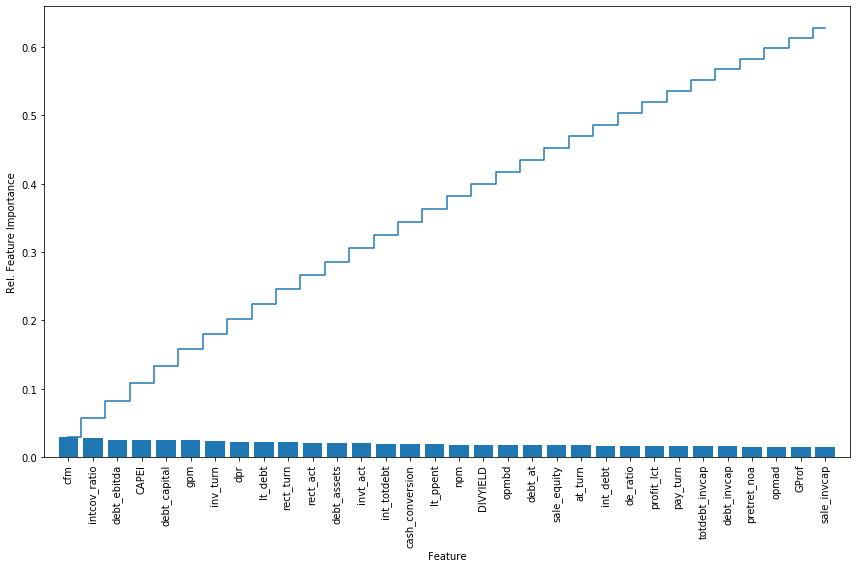

In [21]:
important_features = functions.feature_selection(x = X_train_imputed_lag, y = y_train_lag.values.ravel(), thres=0.015)

In [22]:
#Subset important features matrix for ML algorithms
X_train_imputed_lag = X_train_imputed_lag.loc[:,important_features]
X_test_imputed_lag = X_test_imputed_lag.loc[:, important_features]
X_train_imputed_lag.head(5)

,cfm,intcov_ratio,debt_ebitda,CAPEI,debt_capital,gpm,inv_turn,dpr,lt_debt,rect_turn,...,int_debt,de_ratio,profit_lct,pay_turn,totdebt_invcap,debt_invcap,pretret_noa,opmad,GProf,sale_invcap
6595,0.113,8.40600,1.565,36.030,0.500000,0.423,4.554000,0.334,0.309,4.891,...,0.060000,2.060,0.505000,4.585000,0.382,0.379,0.271000,0.115,0.381,1.665
26131,0.245,21.13200,0.941,24.356,0.230000,0.803,0.844000,0.175,0.523,5.000,...,0.040000,0.523,2.010000,6.532000,0.215,0.215,0.341000,0.304,0.399,0.594
8093,0.254,2.96900,4.441,14.467,0.604000,0.311,11.322000,0.476,0.471,6.879,...,0.055000,2.674,0.695000,9.363000,0.640,0.557,0.081000,0.196,0.089,0.463
23847,-0.054,-12.13433,6.543,68.029,0.375000,0.899,-62.509417,0.000,0.367,6.584,...,-0.133875,1.507,0.129000,16.144603,0.356,0.356,0.017000,0.010,0.448,0.804
25714,0.028,5.34100,4.584,20.875,0.604832,0.101,67.877000,0.547,0.034,0.729,...,0.050000,12.111,-4.529604,2.478718,0.348,0.290,-4.369323,0.101,0.008,0.773


In [23]:
X_train_imputed_lag.to_csv('X_train_lag.csv')
X_test_imputed_lag.to_csv('X_test_lag.csv')
y_train_lag.to_csv('y_train_lag.csv')
y_test_lag.to_csv('y_test_lag.csv')

# Machine Learning Algorithms
## Ordinary Ratings

### Logistic Regression

In [24]:
## Logistic Regression

X_train = pd.read_csv("X_train.csv")
X_train = X_train.iloc[:, 1:]
X_test = pd.read_csv("X_test.csv")
X_test = X_test.iloc[:, 1:]
Y_train = pd.read_csv("y_train.csv")
Y_test = pd.read_csv("y_test.csv")
Y_train = Y_train['Rating as Factor'].astype('category') #factorize trainset
Y_test = Y_test['Rating as Factor'].astype('category')   #factorize testset

In [ ]:
import datetime
print(datetime.datetime.now())
grid = functions.LogReg(X_train,Y_train)
print('Best CV accuracy: {:.4f}'.format(grid.best_score_)) #best parameters are C=7 & ratio=0 -> l2 penalty function
print('Test score:       {:.4f}'.format(grid.score(X_test, Y_test)))
print('Best parameters: {}'.format(grid.best_params_)) #31%
print(datetime.datetime.now()) #10 minutes

2020-04-11 13:55:58.946421


In [ ]:
# Predict classes
y_pred = grid.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

### Support Vector Machines

In [ ]:
#######Polynomial Kernel Function#######
print(datetime.datetime.now()) #computation time
poly = functions.SVM_poly(X_train,Y_train)
print('Best CV accuracy: {:.4f}'.format(poly.best_score_))
print('Test score:       {:.4f}'.format(poly.score(X_test, Y_test)))
print('Best parameters: {}'.format(poly.best_params_))
print(datetime.datetime.now()) #20min

# Predict classes
y_pred = poly.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 


#######Radial Basis Kernel Function(rbf)#######
print(datetime.datetime.now()) #computation time
rbf = functions.SVM_rbf(X_train,Y_train)
print('Best CV accuracy: {:.4f}'.format(rbf.best_score_))
print('Test score:       {:.4f}'.format(rbf.score(X_test, Y_test)))
print('Best parameters: {}'.format(rbf.best_params_))
print(datetime.datetime.now()) #10min

# Predict classes
y_pred = rbf.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print('Radial Basis Function Kernel yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


#######Radial Basis Kernel Function(rbf) with Balanced class weights#######
print(datetime.datetime.now()) #computation time
rbf_bal = functions.SVM_rbf_bal(X_train,Y_train)
print('Best CV accuracy: {:.4f}'.format(rbf_bal.best_score_))
print('Test score:       {:.4f}'.format(rbf_bal.score(X_test, Y_test)))
print('Best parameters: {}'.format(rbf_bal.best_params_))
print(datetime.datetime.now())#10min

#looking at the confusion matrix of non-balanced rbf we see that the smaller classes don't get more wrong classification. Therefore balancing the weights should not influence the outcome greatly which it doesn't


# Predict classes
y_pred = rbf_bal.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print('Radial Basis Function Kernel with Balanced class weights yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

#According to "https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range" the Sigmoid function does not fulfill the definition of a kernel as it is not positive semidefinite. Therefore we will not use it with Support Vector Machines.

### Random Forest

In [ ]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#number of trees in the forest
n_estimators = np.array([70])

# Max depth
maxDepth = np.array([25])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([1])

In [ ]:
#Run RandomForest Classifier
import datetime
print(datetime.datetime.now())
forest = functions.random_forest(X_train,Y_train, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf)
print('Best CV accuracy: {:.4f}'.format(forest.best_score_))
print('Test score:       {:.4f}'.format(forest.score(X_test,Y_test)))
print('Best parameters: {}'.format(forest.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred = forest.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

### MLP Classifier (Neural Network)

In [ ]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#The ith element represents the number of neurons in the ith hidden layer.
hidden_lay = np.array([400])

# Max number of iterations
max_Iter = np.array([575])

In [ ]:
#Run MLP Classifier
import datetime
print(datetime.datetime.now())
mlp = functions.neural(X_train,Y_train, hidden_lay, max_Iter)
print('Best CV accuracy: {:.4f}'.format(mlp.best_score_))
print('Test score:       {:.4f}'.format(mlp.score(X_test,Y_test)))
print('Best parameters: {}'.format(mlp.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred = mlp.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

## Lagging Ratings
### Logistic Regression

In [ ]:
# Logistic Regression

X_train_lag = pd.read_csv("X_train_lag.csv")
X_train_lag = X_train_lag.iloc[:, 1:]
X_test_lag = pd.read_csv("X_test_lag.csv")
X_test_lag = X_test_lag.iloc[:, 1:]
Y_train_lag = pd.read_csv("y_train_lag.csv")
Y_test_lag = pd.read_csv("y_test_lag.csv")
Y_train_lag = Y_train_lag['Lagging-Rating_1M'].astype('category') #factorize trainset
Y_test_lag = Y_test_lag['Lagging-Rating_1M'].astype('category')   #factorize testset

In [ ]:
import datetime
print(datetime.datetime.now())
grid = functions.LogReg(X_train_lag,Y_train_lag)
print('Best CV accuracy: {:.4f}'.format(grid.best_score_))
print('Test score:       {:.4f}'.format(grid.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(grid.best_params_))
print(datetime.datetime.now()) #10 minutes

In [ ]:
# Predict classes
y_pred = grid.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

### Support Vector Machines

In [ ]:
#######Polynomial Kernel Function#######
print(datetime.datetime.now()) #computation time
poly = functions.SVM_poly(X_train_lag,Y_train_lag)
print('Best CV accuracy: {:.4f}'.format(poly.best_score_))
print('Test score:       {:.4f}'.format(poly.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(poly.best_params_))
print(datetime.datetime.now()) #20min

# Predict classes
y_pred = poly.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 


#######Radial Basis Kernel Function(rbf)#######
print(datetime.datetime.now()) #computation time
rbf = functions.SVM_rbf(X_train_lag,Y_train_lag)
print('Best CV accuracy: {:.4f}'.format(rbf.best_score_))
print('Test score:       {:.4f}'.format(rbf.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(rbf.best_params_))
print(datetime.datetime.now()) #10min

# Predict classes
y_pred = rbf.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print('Radial Basis Function Kernel yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))


#######Radial Basis Kernel Function(rbf) with Balanced class weights#######
print(datetime.datetime.now()) #computation time
rbf_bal = functions.SVM_rbf_bal(X_train_lag,Y_train_lag)
print('Best CV accuracy: {:.4f}'.format(rbf_bal.best_score_))
print('Test score:       {:.4f}'.format(rbf_bal.score(X_test_lag, Y_test_lag)))
print('Best parameters: {}'.format(rbf_bal.best_params_))
print(datetime.datetime.now())#10min

#looking at the confusion matrix of non-balanced rbf we see that the smaller classes don't get more wrong classification. Therefore balancing the weights should not influence the outcome greatly which it doesn't


# Predict classes
y_pred = rbf_bal.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print('Radial Basis Function Kernel with Balanced class weights yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted'))

#According to "https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range" the Sigmoid function does not fulfill the definition of a kernel as it is not positive semidefinite. Therefore we will not use it with Support Vector Machines.

### Random Forest

In [ ]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#number of trees in the forest
n_estimators = np.array([70])

# Max depth
maxDepth = np.array([25])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([1])

In [ ]:
#Run RandomForest Classifier
import datetime
print(datetime.datetime.now())
forest = functions.random_forest(X_train_lag,Y_train_lag, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf)
print('Best CV accuracy: {:.4f}'.format(forest.best_score_))
print('Test score:       {:.4f}'.format(forest.score(X_test_lag,Y_test_lag)))
print('Best parameters: {}'.format(forest.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred = forest.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

### MLP Classifier (Neural Network)

In [ ]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#The ith element represents the number of neurons in the ith hidden layer.
hidden_lay = np.array([400])

# Max number of iterations
max_Iter = np.array([575])

In [ ]:
#Run MLP Classifier
import datetime
print(datetime.datetime.now())
mlp = functions.neural(X_train_lag,Y_train_lag, hidden_lay, max_Iter)
print('Best CV accuracy: {:.4f}'.format(mlp.best_score_))
print('Test score:       {:.4f}'.format(mlp.score(X_test_lag,Y_test_lag)))
print('Best parameters: {}'.format(mlp.best_params_))
print(datetime.datetime.now())

# Predict classes
y_pred = mlp.predict(X_test_lag)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': Y_test_lag})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

### Performance Metrics

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confm = confusion_matrix(y_test, y_pred)

In [ ]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#plt.style.use('default')
# Compute confusion matrix
confm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confm, classes=['A', 'A+', 'AA-', 'AAA', 'BBB', 'BBB-', 'AA', 'A-', 'BBB+', 'AA+', 'CCC+', 
                                     'B-', 'B+', 'BB-', 'BB+', 'BB', 'B'],
                      title='Confusion matrix, without normalization');

In [ ]:
print(np.bincount(y_pred))
print(pd.factorize(df["splticrm"])[1])

In [ ]:
FP = confm.sum(axis=0) - np.diag(confm)  
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)

# Metrics
Score = (TP+TN)/(TP+FP+FN+TN)
Errorrate = (FP+FN)/(TP+FP+FN+TN)
Specifity = TN/(TN+FP)
Sensivity = TP/(TP+FN)
Precision = TP/(TP+FP)
F1 = ((1+1**2)*TP)/((1+1**2)*TP+FN+FP)